# Лабораторная работа 2. Метод ближайших соседей и решающие деревья.

ФИО: Полушин Владимир Владимирович

Группа: 317

In [2]:
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

Все эксперименты в этой лабораторной работе предлагается проводить на данных соревнования Amazon Employee Access Challenge: https://www.kaggle.com/c/amazon-employee-access-challenge

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

Для удобства данные можно загрузить по ссылке: https://www.dropbox.com/s/q6fbs1vvhd5kvek/amazon.csv

Сразу прочитаем данные и создадим разбиение на обучение и контроль:

In [32]:
data = pd.read_csv('amazon.csv')
for col_name in data.columns[1:]:
    vals, indices = np.unique(data[col_name], return_inverse=True)
    data[col_name] = indices
data.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,3050,3862,21,64,307,4,7,64,4
1,1,644,156,21,68,299,34,59,66,38
2,1,2706,1533,50,57,14,0,2083,3,0
3,1,2615,867,21,68,181,22,1901,64,23
4,1,3616,941,15,13,157,70,325,4,77


In [33]:
data.shape

(32769, 10)

In [52]:
# доля положительных примеров
data.ACTION.mean()

0.9421099209618847

In [3]:
# число значений у признаков
for col_name in data.columns:
    print col_name, len(data[col_name].unique())

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [34]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = map(lambda d: d.values, train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241))

## Часть 1: kNN и категориальные признаки

#### 1. Реализуйте три функции расстояния на категориальных признаках, которые обсуждались на втором семинаре. Реализуйте самостоятельно метод k ближайших соседей, который будет уметь работать с этими функциями расстояния (учитите, что он должен возвращать вероятность — отношение объектов первого класса среди соседей к числу соседей). Как вариант, можно реализовать метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html), после чего воспользоваться реализацией kNN из sklearn (в этом случае используйте функцию predict_proba).

#### Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Мера качества — AUC-ROC.

Какая функция расстояния оказалась лучшей?

In [85]:
from knn import KnnBlockMerger, KNN
from sklearn.metrics import roc_auc_score

def compute_f(data):
    return [1.0 * np.bincount(data[col_name]) / data.shape[0] for col_name in data.columns]

def compute_cumsum_p2(data):
    f = compute_f(data)
    l = data.shape[0]
    res = []
    for i in xrange(data.shape[1]):
        p2 = 1.0 * f[i] * (f[i] - 1) / l / (l - 1)
        p2_cumsum = np.empty(p2.shape)
        p2_cumsum[np.argsort(p2)] = np.cumsum(np.sort(p2))
        res.append(p2_cumsum)
    return res

def categorial1(x, y, *args, **kwargs):
    return np.sum(x[:, np.newaxis] != y, axis=2)

def categorial2(x, y, *args, **kwargs):
    p2_cumsum = kwargs['p2_cumsum']
    res = np.zeros((x.shape[0], y.shape[0]))
    for i in xrange(x.shape[1]):
        xi = x[:, i]
        yi = y[:, i]
        resi = (xi[:, np.newaxis] != yi) + (xi[:, np.newaxis] == yi) * p2_cumsum[i][yi]
        res += resi
    return res

def categorial3(x, y, *args, **kwargs):
    f = kwargs['f']
    res = np.zeros((x.shape[0], y.shape[0]))
    for i in xrange(x.shape[1]):
        xi = x[:, i]
        yi = y[:, i]
        fi = f[i]
        resi = (xi[:, np.newaxis] != yi) * np.log(fi[yi]) * np.log(fi[xi, np.newaxis])
        res += resi
    return res

p2_cumsum = compute_cumsum_p2(data.iloc[:, 1:])
f = compute_f(data.iloc[:, 1:])

knns = [KnnBlockMerger(KNN(categorial1, n_neighbors=10)), 
        KnnBlockMerger(KNN(categorial2, knn_args={'p2_cumsum': p2_cumsum},n_neighbors=10)),
        KnnBlockMerger(KNN(categorial3, knn_args={'f': f},n_neighbors=10))]

for knn_idx in xrange(len(knns)):
    knns[knn_idx].fit(X_train)
    ans, proba = knns[knn_idx].transform_predict_proba(X_train, y_train, X_test)
    print "Metric {} - auc {}".format(knn_idx + 1, roc_auc_score(y_test, proba))

Metric 1 - auc 0.831668938216
Metric 2 - auc 0.828500899634
Metric 3 - auc 0.82911039011


#### 2 (бонус). Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какое наилучшее качество удалось достичь?

In [48]:
def iterate_parameter(current_values, parameters, calc_func, current_anss):
    parameter, values = parameters[0]
    if len(parameters) == 1:
        arr = []
        for value in values:
            current_values[parameter] = value
            ans = calc_func(current_values)
            arr.append(ans)
            current_anss.append((current_values.copy(), ans))
        current_values.pop(parameter)
        plt.plot(values, arr, label=str(parameter))
        plt.xlabel(str(parameter))
        plt.title('\n'.join(["{} = {}".format(p, v) for p, v in current_values.iteritems()]))
        plt.show()
    else:
        for value in values:
            current_values[parameter] = value
            iterate_parameter(current_values, parameters[1:], calc_func, current_anss)
    
def grid_search(parameters_values, calc_func):
    res = []
    iterate_parameter(dict(), parameters_values, calc_func, res)
    best_ans = max(res, key=lambda p: p[1])
    print "Best params:", best_ans[0]
    print "Best precision:", best_ans[1]

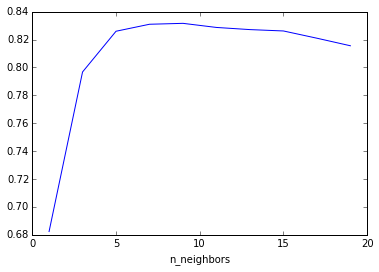

Best params: {'n_neighbors': 9}
Best precision: 0.831650248253


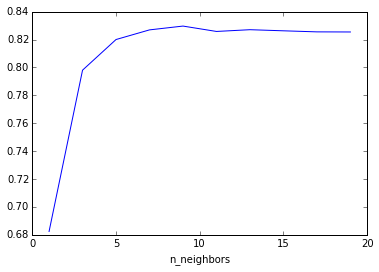

Best params: {'n_neighbors': 9}
Best precision: 0.829693552897


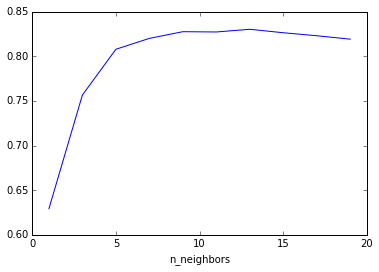

Best params: {'n_neighbors': 13}
Best precision: 0.830309512976


In [87]:
def run_knn(knn_obj):
    knn_obj.fit(X_train)
    ans, proba = knn_obj.transform_predict_proba(X_train, y_train, X_test)
    return roc_auc_score(y_test, proba)

def calc1(values):
    knn_obj = KnnBlockMerger(KNN(categorial1, **values))
    return run_knn(knn_obj)

def calc2(values):
    knn_obj = KnnBlockMerger(KNN(categorial2, knn_args={'p2_cumsum': p2_cumsum}, **values))
    return run_knn(knn_obj)

def calc3(values):
    knn_obj = KnnBlockMerger(KNN(categorial3, knn_args={'f': f}, **values))
    return run_knn(knn_obj)    
    
maxk = 20
    
grid_search([('n_neighbors', range(1, maxk + 1, 2))], calc1)
grid_search([('n_neighbors', range(1, maxk + 1, 2))], calc2)
grid_search([('n_neighbors', range(1, maxk + 1, 2))], calc3)

#### 3. Реализуйте счетчики (http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx), которые заменят категориальные признаки на вещественные.

А именно, каждый категориальный признак нужно заменить на три: 
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `clicks` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`clicks` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `clicks` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанный по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

#### Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

In [45]:
def convert_to_counters(X, X_fold, y_fold):
    l = X.shape[1]
    res = np.empty((X.shape[0], l * 3))
    # counts
    for i in xrange(l):
        counts = np.bincount(X_fold[:, i])
        counts.resize(X[:, i].max() + 1)
        res[:, i] = 1.0 * counts[X[:, i]] / X_fold.shape[0]
    # clicks
    for i in xrange(l):
        clicks = np.bincount(X_fold[:, i][y_fold == 1])
        clicks.resize(X[:, i].max() + 1)
        res[:, l + i] = 1.0 * clicks[X[:, i]] / X_fold.shape[0]
    # (clicks + 1) / (counts + 2)
    res[:, 2*l:] = (res[:, l:2*l] * X_fold.shape[0] + 1) / (res[:, 0:l] * X_fold.shape[0] + 2)
    return res

def convert_to_counters_fold(X, y, nfolds=3):
    res = np.empty((X.shape[0], X.shape[1] * 3))
    for idx_train, idx_test in KFold(X.shape[0], nfolds):
        res[idx_test] = convert_to_counters(X[idx_test], X[idx_train], y[idx_train])
    return res

In [43]:
def run_algorithm(Classifier, X_train, y_train, X_test, y_test):
    def run(values):
        clf = Classifier(**values).fit(X_train, y_train)
        proba = clf.predict_proba(X_test)
        return roc_auc_score(y_test, proba[:, 1])
    return run

In [63]:
from sklearn.cross_validation import KFold
from sklearn.neighbors import KNeighborsClassifier

def test_data_with_counters(X, y, X_test, y_test, max_k = 200, nfolds = 3):
    X_counters = convert_to_counters(X, X, y)
    X_test_counters = convert_to_counters(X_test, X, y)
    X_counters_fold = convert_to_counters_fold(X, y, nfolds)
    
    
    print "Without folding"
    grid_search([('n_neighbors', range(1, max_k + 1, 10))], run_algorithm(KNeighborsClassifier, 
                                                                          X_counters, y, 
                                                                          X_test_counters, y_test))
    print "With folding"
    grid_search([('n_neighbors', range(1, max_k + 1, 10))], run_algorithm(KNeighborsClassifier, 
                                                                          X_counters_fold, y, 
                                                                          X_test_counters, y_test))

Without folding


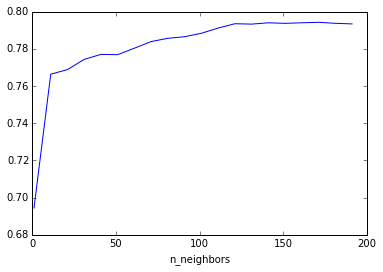

Best params: {'n_neighbors': 171}
Best precision: 0.794293325311
With folding


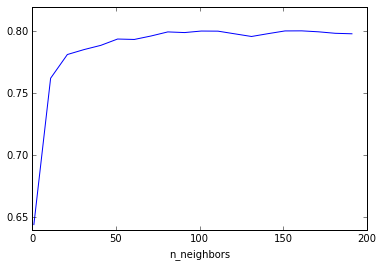

Best params: {'n_neighbors': 161}
Best precision: 0.800515825007


In [64]:
test_data_with_counters(X_train, y_train, X_test, y_test)

#### 4. Добавьте в исходную выборку парные признаки — то есть для каждой пары $f_i$, $f_j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$. Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

Without folding


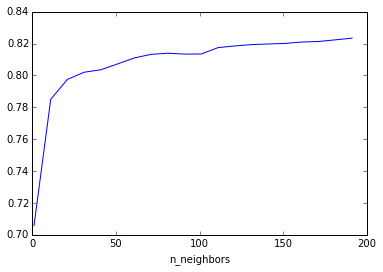

Best params: {'n_neighbors': 191}
Best precision: 0.823403931074
With folding


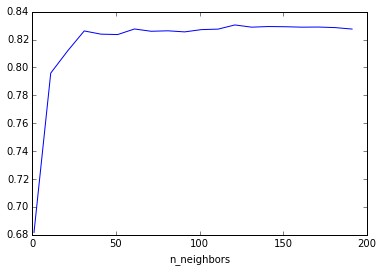

Best params: {'n_neighbors': 121}
Best precision: 0.830500456107


In [65]:
def convert_to_pairwise_features(X_train, X_test):
    X = np.vstack((X_train, X_test))
    l = X.shape[1]
    res = np.empty((X.shape[0], l + l * (l - 1) / 2), dtype=int)
    res[:, 0:l] = X
    nowl = l
    for i in xrange(l):
        for j in xrange(i + 1, l):
            conc_features = np.empty(X.shape[0], dtype='int,int')
            conc_features['f0'] = X[:, i]
            conc_features['f1'] = X[:, j]
            vals, indices = np.unique(conc_features, return_inverse=True)
            res[:, nowl] = indices
            nowl += 1
    return res[:X_train.shape[0]], res[X_train.shape[0]:]

pairwise_X_train, pairwise_X_test = convert_to_pairwise_features(X_train, X_test)
test_data_with_counters(pairwise_X_train, y_train, pairwise_X_test, y_test)

## Часть 2: Решающие деревья и леса

#### 1. Возьмите из предыдущей части выборку с парными признаками, преобразованную с помощью счетчиков без фолдинга. Настройте решающее дерево, подобрав оптимальные значения параметров `max_depth` и `min_samples_leaf`. Какой наилучший AUC-ROC на контроле удалось получить?

In [66]:
pair_X_train = convert_to_counters(pairwise_X_train, pairwise_X_train, y_train)
pair_X_test = convert_to_counters(pairwise_X_test, pairwise_X_train, y_train)

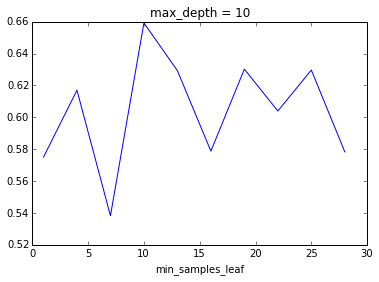

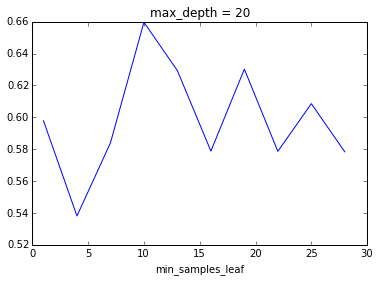

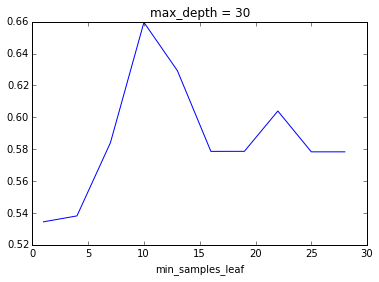

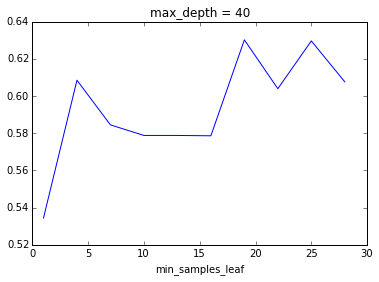

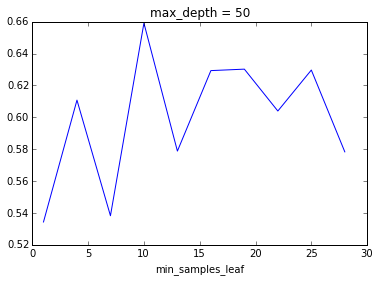

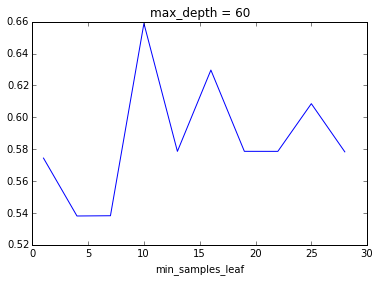

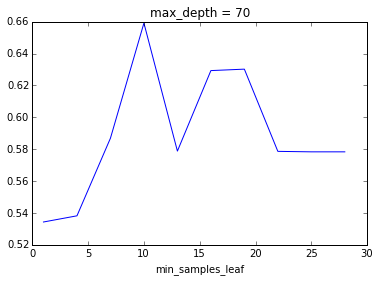

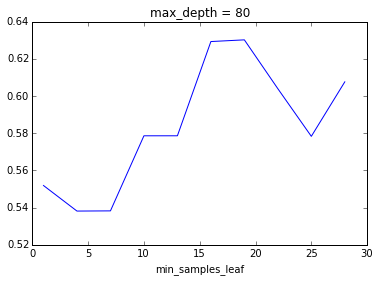

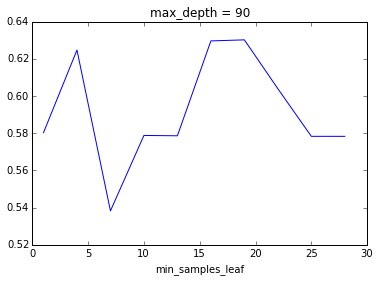

Best params: {'max_depth': 20, 'min_samples_leaf': 10}
Best precision: 0.659664939283


In [71]:
from sklearn.tree import DecisionTreeClassifier

grid_search([('max_depth', range(10, 100, 10)),
             ('min_samples_leaf', range(1, 30, 3))], run_algorithm(DecisionTreeClassifier, 
                                                                   pair_X_train, y_train, 
                                                                   pair_X_test, y_test))

#### 2. Настройте случайный лес, подобрав оптимальное число деревьев `n_estimators`. Какое качество на тестовой выборке он дает?

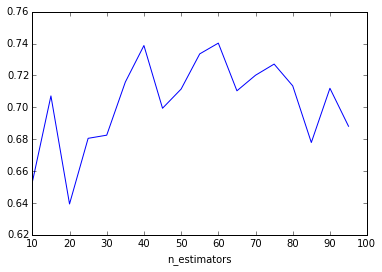

Best params: {'n_estimators': 60}
Best precision: 0.740286790294


In [76]:
from sklearn.ensemble import RandomForestClassifier
        
grid_search([('n_estimators', range(10, 100, 5))], run_algorithm(RandomForestClassifier,
                                                                 pair_X_train, y_train,
                                                                 pair_X_test, y_test))

#### 3. Возьмите выборку с парными признаками, для которой счетчики посчитаны с фолдингом. Обучите на ней случайный лес, подобрав число деревьев. Какое качество на тестовой выборке он дает? Чем вы можете объяснить изменение результата по сравнению с предыдущим пунктом?

In [77]:
pair_X_train_fold = convert_to_counters_fold(pairwise_X_train, y_train)

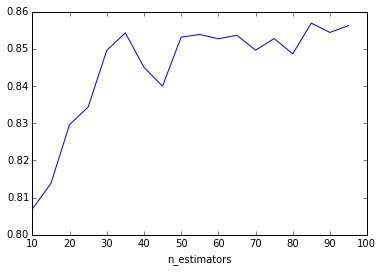

Best params: {'n_estimators': 85}
Best precision: 0.85692950146


In [79]:
grid_search([('n_estimators', range(10, 100, 5))], run_algorithm(RandomForestClassifier,
                                                                 pair_X_train_fold, y_train,
                                                                 pair_X_test, y_test))

Я думаю, результат этого пункта оказался существенно (по сравнению с другими алгоритмами) выше, потом что random forest при построении деревьев обрезает признаки, и поэтому, например, счетчики clicks, которые содержат информацию о тесте, начинают играть большую роль чем в том же kNN. Таким образом, фолдинг, который уменьшает переобучение, становится все более заметным. 